# PyGeM
## Tutorial 6: Deformation of the computational mesh through an RBF interpolator

In this tutorial we're going to show the procedure to propagate a given object deformation to the computational grid built around such a object. In this way, any deformation mapping we can apply to the object to morph is replicated to all discretized space around it, avoiding the expensive re-meshing phase. In this tutorial we just show the needed steps to achieve such parametric mesh exploiting the **PyGeM** package, presenting a very simple test-case, but for a practical real-world usecase we refer to
-  Hull Shape Design Optimization with Parameter Space and Model Reductions, and Self-Learning Mesh Morphing
by Nicola Demo, Marco Tezzele, Andrea Mola and Gianluigi Rozza. J. Mar. Sci. Eng. 2021, 9(2), 185; https://doi.org/10.3390/jmse9020185.


### The numerical settings
The methodology that follows is very general and can be extended to many different scenario, since it basically requires only the coordinates of the nodes of the object geometry and of the (undeformed) initial mesh. For sake of simplicity, here we present the deformation of an [OpenFOAM](https://openfoam.org/) grid for simulating a 2D Navier-Stokes flow around a cylinder. We assume that this cilinder is the object to deform.
Even if the entire procedure is employable also when the deformation mapping applied to the initial object is unknown (we see in few lines that the required input is just the displacement of the initial object after the deformation), here we apply the *free-form deformation* method to the undeformed cylinder in order to parametrize its geometry.

First of all, we import all the libraries which we're going to use:
- `numpy` and `matplotlib` for the generic scientific environment;
- `Smithers` for dealing with the OpenFOAM mesh;
- `PyGeM` for the object and mesh deformation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# mesh parsing
from smithers.io.openfoam.openfoamhandler import OpenFoamHandler
# interpolator
from scipy.interpolate import Rbf
# deformation
from pygem import FFD, RBF

Then we define the auxiliary function `scatter3d` which we're going to use often to plot several objects as lists of 3D points. You do not need to understand the exact details of this function since we are going to use it only to show the results:

In [2]:
def scatter3d(arr, figsize=(8,8), s=10, draw=True, ax=None, alpha=1, labels=None, original_control_points=None, control_points=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(projection='3d')
        
    for idx,a in enumerate(arr):
        if labels is not None:
            ax.scatter(*a.T, s=s, alpha=alpha, label=labels[idx])
        else:
            ax.scatter(*a.T, s=s, alpha=alpha)
    
    if control_points.any():
        ax.scatter(*control_points.T, s=50, c='red')
    if original_control_points.any():
        ax.scatter(*original_control_points.T, s=50, c='gray')
        
    if draw:
        if labels is not None:
            plt.legend()
        plt.show()
    else:
        return ax

## 1) Extraction of the mesh points

In few words, the procedure uses the the nodes coordinates of the deformed object in order to fit the RBF interpolator which will propagate such morphing to the computational grid.
The first step is then the extraction of such points: we specify that, for avoiding that also the mesh boundaries are deformed, we need to force a *zero* displacement there. We can easily obtain that by passing these bondaries as the RBF control points.

As we mentioned before, in this tutorial we use the library `Smithers` to load the OpenFOAM mesh from the folder `openfoam_mesh` which serves as example. First of all, we use the method `read()` from the class `OpenFoamHandler` to load the data. This method returns a dictionary which contains all the informations available about the mesh, included the list of points (`mesh['points']`).

In [3]:
from smithers.io.obj.objhandler import ObjHandler

In [4]:
# we load the OpenFOAM mesh
objhandler = ObjHandler()
mesh = objhandler.read("foam_mesh/constant/geometry/body.obj")

skipping: ['#', 'points', ':', '125446']
skipping: ['#', 'faces', ':', '250962']


Moreover, the object returned by `read()` contains a list of points for each *boundary*, represented by a list of indexes which refers to `mesh['points']`. We can use these lists to obtain the coordinates of the points which compose the cylinder (which we call *obstacle*) and walls.

In [5]:
obstacle=mesh.vertices  #WavefrontOBJの変数を参照

At this point we can plot the obstacle and the walls using the auxiliary function `scatter3d`:

In [6]:
# 間引き用のindex
ratio = 0.2
n_points = len(mesh.vertices)

idx = np.array(range(n_points))
np.random.shuffle(idx)
sample_idx = idx[:int(n_points*ratio)]

As you can see our geometry is made of two faces, one at `z=0.5` and the other at `z=-0.5`.

## 2) Object Deformation

Here we need to apply a generic deformation on the initial object (the cylinder here). In case this deformation is already computed, you can skip this section, having the forethought of storing the nodes coordinates of the undeformed and deformed object.

We use the `FFD` deformation from [PyGeM](https://github.com/mathLab/PyGeM) (for a reference check [this tutorial](http://mathlab.github.io/PyGeM/tutorial-1-ffd.html)) to deform the original object (the upper and lower faces of a cylinder). We create the new `FFD` object and set its attributes in order to create a simple deformation

In [7]:
ffd = FFD([2, 2, 2])

ffd.box_origin = np.array([-1, -1.2, 0.0])
ffd.box_length = np.array([5, 2.4,  1.5])

ffd.array_mu_x[0, 0, 1] = -0.4
ffd.array_mu_y[0, 0, 1] = 0.4
ffd.array_mu_z[0, 0, 1] = 0.0

ffd.array_mu_x[0, 1, 1] = 0.4
ffd.array_mu_y[0, 1, 1] = 0.4
ffd.array_mu_z[0, 1, 1] = 0.0

ffd.array_mu_x[1, 0, 1] = -0.4
ffd.array_mu_y[1, 0, 1] = -0.4
ffd.array_mu_z[1, 0, 1] = 0.0

ffd.array_mu_x[1, 1, 1] = 0.4
ffd.array_mu_y[1, 1, 1] = -0.4
ffd.array_mu_z[1, 1, 1] = 0.0

ffd.control_points()

array([[-1.  , -1.2 ,  0.  ],
       [-3.  , -0.24,  1.5 ],
       [-1.  ,  1.2 ,  0.  ],
       [ 1.  ,  2.16,  1.5 ],
       [ 4.  , -1.2 ,  0.  ],
       [ 2.  , -2.16,  1.5 ],
       [ 4.  ,  1.2 ,  0.  ],
       [ 6.  ,  0.24,  1.5 ]])

We then operate the deformation and plot the result, against the old version of the obstacle.

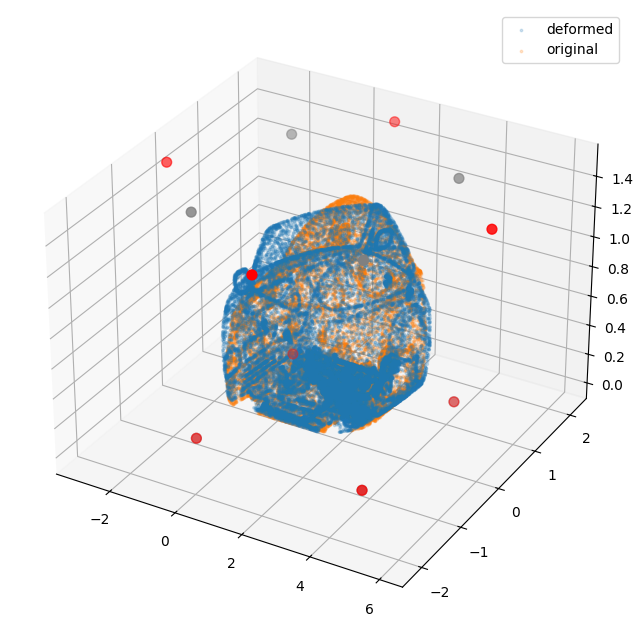

In [8]:
new_obstacle = ffd(obstacle)
scatter3d(
    [new_obstacle[sample_idx], obstacle[sample_idx]], 
    s=3, labels=['deformed', 'original'], 
    original_control_points=ffd.control_points(deformed=False), control_points=ffd.control_points(deformed=True),
    alpha=0.2
)

In [9]:
# 元のメッシュに上書きし，objファイルを保存

import copy
new_mesh=copy.copy(mesh)
new_mesh.vertices=new_obstacle

objhandler.write(new_mesh, "new_body.obj")